# Formalia:

Please read the [assignment overview page](https://github.com/SocialComplexityLab/socialgraphs2024/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday November 5th, 2024 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via DTU Learn

In [145]:
# Standard Library imports
import os
import re
import math
import json
import random
import string
import urllib.request
from collections import Counter, defaultdict

# Third-party library imports
import numpy as np  
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import community.community_louvain as community
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# NLTK library imports
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

##### Code for Generating Artist Network from Genre Data

In [146]:
# Load singer data from 'artists_genres_dictionary.txt'
with open('artists_genres_dictionary.txt', 'r') as f:
    genres_data = json.load(f)

# Lets use wikipedia API to get the page of the artists
def get_wiki(title):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    content = "prop=revisions&rvprop=content"
    dataformat = "format=json"
    
    # URL-encode the title to handle spaces and special characters
    title = "titles={}".format(urllib.parse.quote(title))
    
    # Build the query URL
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    
    # Make the request to Wikipedia API
    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    
    # Decode and return the JSON data
    wikitext = wikidata.decode('utf-8')
    return json.loads(wikitext)

def extract_page_content(wiki_data):
    try:
        # Get the page key (pageid) dynamically (since page IDs can vary)
        page = list(wiki_data['query']['pages'].values())[0]
        return page['revisions'][0]['*']  # Return the raw page content
    except KeyError:
        return None  # In case there's no content found
    
# Function to format a valid filename from an artist name
def format_filename(artist_name):
    # Remove characters that are invalid for filenames on most systems
    return re.sub(r'[\\/*?:"<>|]', '', artist_name)

# Create a list of artist names
artist_names = list(genres_data.keys())

# Output directory for saving Wikipedia pages
output_dir = "wikipedia_pages"

# Loop through each artist, fetch their Wikipedia page, and save it
for artist in artist_names:
    # Format the filename and create the full path
    filename = format_filename(artist) + ".txt"
    file_path = os.path.join(output_dir, filename)

    # Check if the file already exists; if so, skip to the next artist
    if os.path.exists(file_path):
        continue

    # Query Wikipedia and retrieve page content if file does not exist
    wiki_data = get_wiki(artist)
    page_content = extract_page_content(wiki_data)
    
    if page_content:
        # Write the page content to a text file
        with open(file_path, 'w', encoding='utf-8') as f:
            f.write(page_content)
        print(f"Successfully saved Wikipedia page for {artist} to {file_path}") # Print success message if file is saved because the file did not exist
    else:
        print(f"Wikipedia page for {artist} does not exist or has no content.")

# Function to get the names of connected artists from the Wikipedia page content
def get_connected_names(content):
    # Find matches within [[...]]
    matches = re.findall(r'\[\[(.*?)\]\]', content)
    
    # Clean up each match to standardize the format
    connected_names = []
    for match in matches:
        # Remove text within parentheses and after '|'
        name = re.sub(r'\(.*?\)|\|.*', '', match).strip()
        connected_names.append(name)
    return connected_names

# Function to filter out non-artist names from the artist_names list
def filter_connected_names(connected_names, singer_names):
    filtered_names = [name for name in connected_names if name in singer_names]
    return filtered_names

# Function to count the number of words in a given content
def count_words(content):
    return len(re.findall(r'\b\w+\b', content))

# Function to create the graph
def create_map(folder_path, singer_names):
    # Convert folder path to absolute path
    folder_path = os.path.abspath(folder_path)
    
    # Initialize an undirected graph
    G = nx.Graph()

    for artist in singer_names:
        # Prepare file path
        artist_filename = format_filename(artist)
        file_path = os.path.join(folder_path, f"{artist_filename}.txt")

        # Skip if file does not exist
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue

        # Open and read content
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read().strip()
        
        # Calculate content length if content is not empty
        content_length = count_words(content) if content else 0

        # Add artist as a node with content_length attribute
        G.add_node(artist, content_length=content_length)
        
        # Process and filter connected names for edge addition
        filtered_names = filter_connected_names(get_connected_names(content), singer_names)
        G.add_edges_from((artist, name) for name in filtered_names)   
        
    return G

# The folder 'wikipedia_pages' contains the wikipedia pages content of every artist in the artist_names list
folder_path = 'wikipedia_pages'
# Create Graph
G = create_map(folder_path, singer_names=artist_names)
# Delete self loops
G.remove_edges_from(nx.selfloop_edges(G))

# Print the number of nodes and edges in the graph
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph has 1833 nodes and 13467 edges.


# Part 1: Genres and communities and plotting 

The questions below are based on Lecture 7, part 2.

* Write about genres and modularity.
* Detect the communities, discuss the value of modularity in comparison to the genres.
* Calculate the matrix $D$ and discuss your findings.
* Plot the communities and comment on your results.

### Genres and Modularity in Community Detection

Modularity is a metric used to assess the quality of community partitions in a network. It provides a novel approach to detecting meaningful communities by evaluating how well a network is divided. Higher modularity values indicate better-defined communities within the network, whereas lower values imply weaker or less significant structures:

- **High Modularity**: Suggests strong community structure, with nodes within each community being densely connected while connections between communities are sparse.
- **Zero Modularity**: Implies a random network structure with no meaningful communities.
- **Negative Modularity**: Indicates that the current community arrangement is worse than a random distribution, which may suggest issues with the network’s partitioning.

The modularity for a community $M_c$ and the overall modularity $M$ are calculated as follows (for parameter details, see [Network Science Chapter 9](https://networksciencebook.com/chapter/9), formulas 9.9, 9.10, 9.11):

$$
M_c = \frac{1}{2L} \sum_{(i,j) \in C_c} (A_{ij} - p_{ij}) = \frac{L_c}{L} - \left(\frac{k_c}{2L}\right)^2
$$

$$
M = \sum_{c} M_c = \sum^{(n_c)}_{c=1} \frac{L_c}{L} - \left(\frac{k_c}{2L}\right)^2
$$

### Genre Distribution and Community Analysis

Genres, stored in each singer’s Wikipedia page content, serve as identifiers and may inform community structure. Based on the data in `artists_genres_dictionary.txt`, the top 20 genres reveal an uneven distribution. Country music is the most common genre with 1,499 artists, while all other genres have fewer than 200 artists. This genre distribution provides insight into potential community divisions, as artists sharing genres are likely to form dense clusters, enriching the modularity of the network. Further analysis can explore how genres influence community structure across the network.

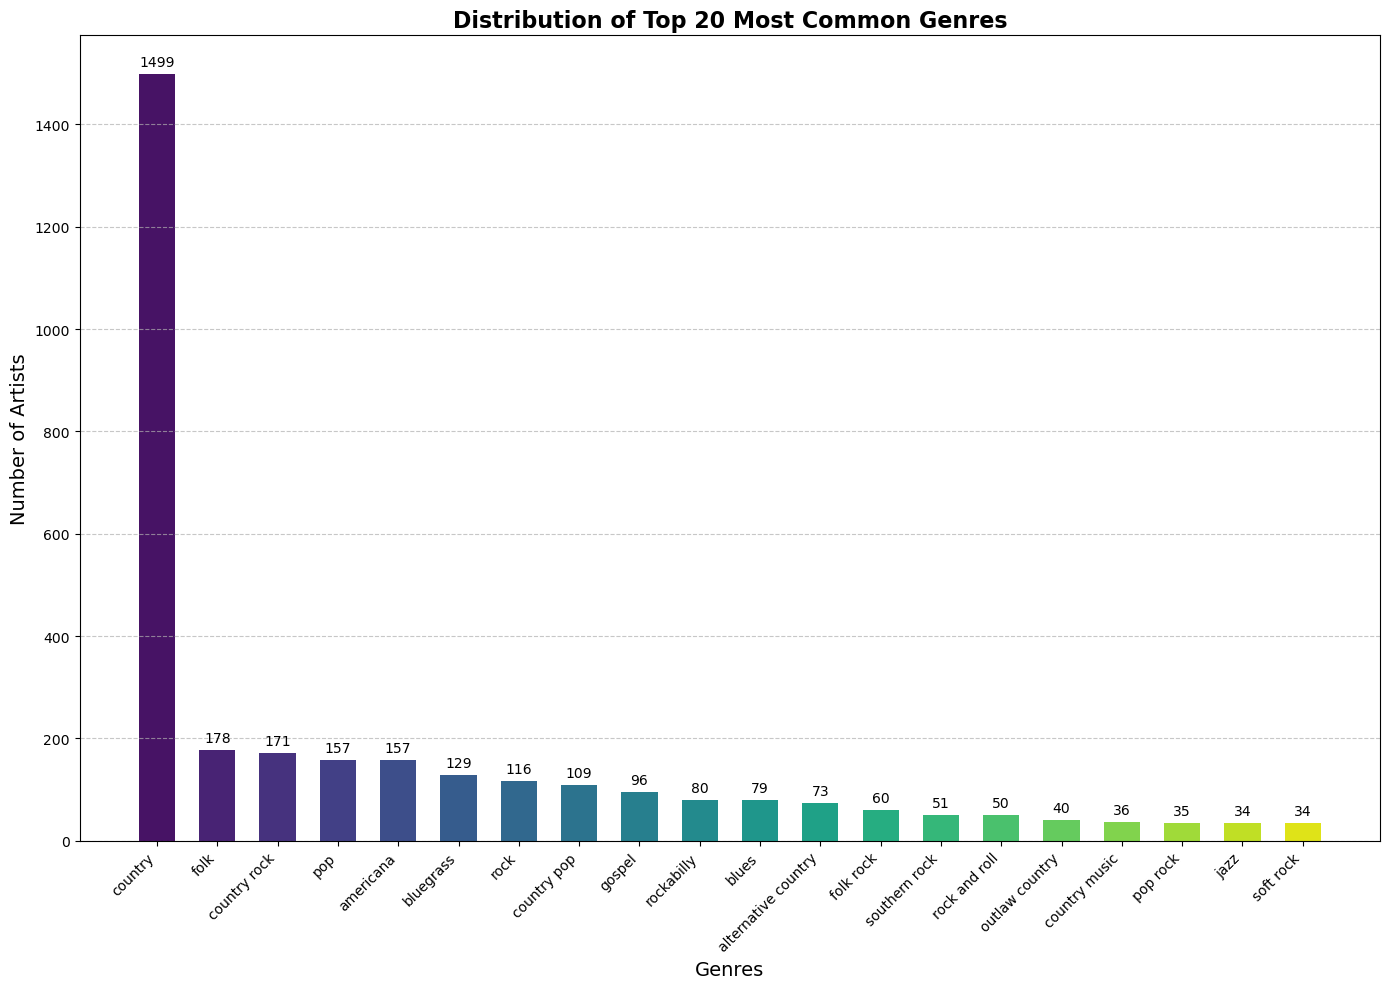

In [147]:
# Compute the different genres of the artists
all_genres = [genre for genres_list in genres_data.values() for genre in genres_list]

# Count the occurrences of each genre
genre_counts = Counter(all_genres)

# Get the top 20 most common genres
top_20_genres = dict(genre_counts.most_common(20))

# Use a color palette from seaborn
colors = sns.color_palette("viridis", len(top_20_genres))

# Plot the top 20 genres with enhancements
plt.figure(figsize=(14, 10))
bars = plt.bar(top_20_genres.keys(), top_20_genres.values(), color=colors, width=0.6)

# Rotate x-tick labels for readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Add title and labels with enhanced font size and weight
plt.title('Distribution of Top 20 Most Common Genres', fontsize=16, weight='bold')
plt.xlabel('Genres', fontsize=14)
plt.ylabel('Number of Artists', fontsize=14)

# Add gridlines for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar with the corresponding value
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 10,
        f'{int(bar.get_height())}',
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()

### Detect the communities, discuss the value of modularity in comparison to the genres.
### Plot the communities and comment on your results.
For the better explaination these two questions will be answered together.

The plotting part instead of appling in python code with library ForceAtlas2 we chose another method use a more prefessional software [Gephi](https://github.com/gephi/gephi) to better and more accurate representation of network structure. After the parition of the community of each network we will downlaod them as the .gexf file and visual simulation on Gephi, the parameteres setted as follow: 
- `threads`: 7
- `tolerance`: 1.0
- `approximateRepulsion`: True
- `scaling`: 3.0
- `stronger_gravity`: False
- `gravity`: 1.0
- `dissuadeHubs`: False
- `linLogMode`: False
- `preventOverlap`: False
- `edgeWeightInfluence`: 1.0

In [148]:
# define a method to calculate the modularity
def calculate_modularity(G, communities):
    node_to_index = {node: idx for idx, node in enumerate(G.nodes())}
    A = nx.to_numpy_array(G, nodelist=G.nodes())  # adjacency matrix for whole network
    L = G.number_of_edges()
    degrees = dict(G.degree())
    modularity = 0.0

    for community in communities:
        indices = [node_to_index[node] for node in community] # indices of nodes in community
        subgraph = A[np.ix_(indices, indices)] # adjacency matrix for community
        ki = np.array([degrees[node] for node in community]) # degree of nodes in community

        # Sum over all pairs including i == j
        sum_Aij = np.sum(subgraph)
        sum_kikj = np.sum(np.outer(ki, ki)) / (2 * L)

        modularity += (sum_Aij - sum_kikj) # sum over all communities

    modularity /= (2 * L) # divide by 2L
    return modularity

In [149]:
#create the graph for the genres community question
G_genres = G
# assign each nodes as their first genre
node_genres = {}
for artist, genres in genres_data.items():
    node_genres[artist] = genres[0] if genres else 'unknown'
nx.set_node_attributes(G_genres, node_genres, 'genre')
# svae the graph as gexf for visualization
nx.write_gexf(G_genres, 'G_genres.gexf')
# put the nodes into the corresponing communities
genre_communities = defaultdict(list)
for node, data in G_genres.nodes(data=True):
    genre = data.get('genre', 'unknown')
    genre_communities[genre].append(node)

# calculate the modularity
M = calculate_modularity(G_genres, genre_communities.values())

print("modularity of the first genres(include contry):", M)

modularity of the first genres(include contry): 0.07098935918585711


![The graphy parition of the community by genres](G_genres.png)

In [150]:
#create the graph for the genres community question
G_genres_1 = G
# assign each nodes as their first genre, if the first genre is country, assign the second genre as the genre
node_genres = {}
for artist, genres in genres_data.items():
    if genres and genres[0] == 'country' and len(genres) > 1:
        non_country_genre = next((g for g in genres if g != 'country'), 'country')
        node_genres[artist] = non_country_genre
    else:
        node_genres[artist] = genres[0] if genres else 'unknown'
nx.set_node_attributes(G_genres_1, node_genres, 'genre')
# svae the graph as gexf for visualization
nx.write_gexf(G_genres_1, 'G_genres_without_country.gexf')
# put the nodes into the corresponing communities
genre_communities = defaultdict(list)
for node, data in G.nodes(data=True):
    genre = data.get('genre', 'unknown')
    genre_communities[genre].append(node)

# calculate the modularity
M = calculate_modularity(G_genres_1, genre_communities.values())
print("modularity of the first genres(not include contry):", M)

modularity of the first genres(not include contry): 0.08335525519068318


![](Genres_country_adjust.png)

In [151]:
# create a graph for Louvain community detection
G_Lou = G

# apply Louvain-algorithm
partition = community.best_partition(G_Lou, random_state=42)
# set the community attribute for each node
for i in partition:
    G_Lou.nodes[i]['community'] = partition[i]
list(G_Lou.nodes(data=True))[:5]
# save the graph as gexf for visualization
nx.write_gexf(G_Lou, 'G_Lou.gexf')

# adjust the format of the partition for calculation of the modularity
result = defaultdict(list)
for key, value in partition.items():
    result[value].append(key)

M = calculate_modularity(G_Lou, result.values())
print("modularity of Louvain-algorithm:", M)

modularity of Louvain-algorithm: 0.38351457524924354


![](G_Lou.png)

### Analysis based on Modularity and Visual Representation

**Louvain Algorithm (0.3835):**  
The modularity score obtained using the Louvain algorithm is 0.3835, indicating a relatively strong community structure. Modularity is a measure that evaluates the quality of a network's division into communities; a score approaching 1 suggests that the communities are well-defined and more compact. The Louvain method seeks to maximize this score by finding the best partition of the network, resulting in groups of nodes that are more densely connected to each other than to the rest of the network. In this context, the score of 0.3835 suggests that the algorithm has successfully identified clear patterns in node connectivity, revealing communities that have significant interactions.

**Genres Including Country (0.0709):**  
On the other hand, the modularity score when including genres, specifically considering the "country" genre, is 0.0709. This figure is notably lower compared to the Louvain algorithm's score, indicating that this partition does not reflect strong modular community structures. One possible reason for this low score is that many artists have "country" as their primary genre label, leading to overlapping communities that become less distinct from each other. The dominance of this genre may result in a lack of clarity in identifying different communities within the network.

**Genres Excluding Country (0.0834):**  
When analyzing modularity by excluding the "country" genre and selecting the first distinct genre from the artist's list, the modularity score increases slightly to 0.0834. This suggests that removing the "country" genre helps better define the remaining communities. The presence of this genre seems to dilute the strength of the community structure, making the boundaries between different communities less clear. However, although an improvement is observed, the score remains relatively low, indicating that the communities are still not as strong as those identified by the Louvain algorithm.

**Interpretation of Community Structure:**  
The partition generated by the Louvain algorithm clearly shows well-defined community structures, as indicated by its high modularity score. In contrast, partitions based on musical genres tend to be weaker, especially when the "country" genre is present. This highlights that the country genre is not only dominant but may also overlap with other labels, complicating the identification of more discrete communities. When manipulation is done to select the first genre distinct from "country," it becomes evident that the communities formed by the remaining genres are somewhat clearer, although they still do not reach the strength of those identified by the Louvain algorithm.

**Visual Comparison:**  
The visualization of the Louvain algorithm results shows distinct and well-separated clusters, corroborating its high modularity score. In contrast, genre-based visualizations reveal a greater mix of nodes, where communities are not clearly defined. Using the "country" genre and observing the effect of its inclusion aligns with the visualization, indicating that removing the predominant genre highlights smaller and better-defined communities.

**Conclusion:**  
In conclusion, the higher modularity score of the Louvain algorithm underscores its effectiveness in identifying the natural community structure within the network, surpassing the genre-based partitions. The strong presence of the "country" genre appears to contribute to a less defined community structure when included. This observation is reflected in the analysis, where a slight improvement in modularity is achieved by avoiding the "country" genre, suggesting that other communities may become more prominent when this genre is excluded.

### Calculate the matrix $D$ and discuss your findings.
The matrix below shows the distribution of the 7 most common genres across the 7 largest communities. Each entry in the matrix
$D(i,j)$ represents the number of nodes of genre $i$ that belong to community $j$.

Country nodes are well distributed across multiple communities, especially in columns 0, 2, and 6, indicating that these communities are highly consistent with the country genre, showing that the Louvain algorithm is able to detect significant clusters related to country music.<br>
Bluegrass shows a strong presence in community 2, indicating that this community may specifically represent bluegrass music or styles closely related to it.

The folk and americana genres both have a high number of nodes in community 1, showing the similarity and possible intersection between the two genres. Meanwhile the highest number of country rock and rock are in community 1 alone with the massive country distribution which indicates there may be a potential relation between country rock, rock, and country.<br>
Pop and rock nodes are distributed in multiple communities, especially in communities 0 and 6. This diversity of distribution suggests that pop and rock music may have some fusion or intersection with other genres such as country and country rock.

In conclusion, the confusion matrix shows that the communities detected by Louvain generally correspond well to genres, especially for mainstream genres such as country, folk, americana, and bluegrass. Genres like pop and rock show distribution in multiple communities, reflecting their broader cross-genre influence or hybrid nature. The analysis shows that the algorithm performs well in capturing communities associated with core genres, but there is overlap in communities of some fused genres.

                 0      2      1      6      5     7     10
country       379.0  321.0  246.0  305.0  129.0  36.0  31.0
folk            9.0   30.0   95.0   26.0    3.0   4.0   5.0
country rock   57.0   18.0   63.0   14.0    4.0   0.0   5.0
pop            48.0   13.0   31.0   48.0   11.0   2.0   2.0
americana      15.0   16.0   98.0   12.0    4.0   3.0   1.0
bluegrass      10.0   77.0   31.0    7.0    1.0   0.0   0.0
rock           21.0   16.0   50.0   14.0    6.0   3.0   3.0


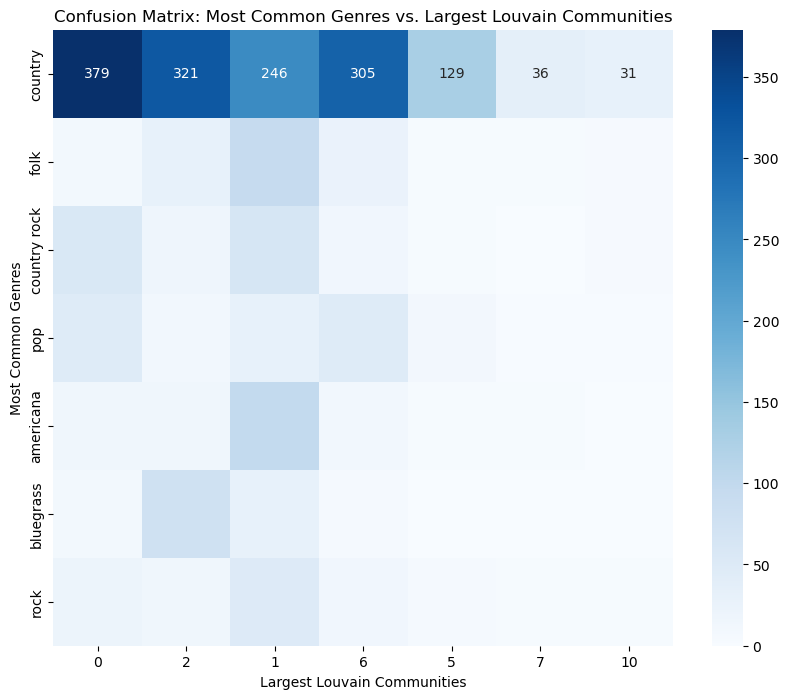

In [152]:
# Convert the partition result into a format of community sizes
louvain_communities = defaultdict(list)
for node, comm_id in partition.items():
    louvain_communities[comm_id].append(node)

# Identify the 7 largest communities by size
community_sizes = {comm_id: len(nodes) for comm_id, nodes in louvain_communities.items()}
largest_communities = sorted(community_sizes, key=community_sizes.get, reverse=True)[:7]

# Map the largest communities to indices
community_to_index = {community: j for j, community in enumerate(largest_communities)}

# Identify the 7 most common genres
all_genres = [genre for genres in genres_data.values() for genre in genres]
most_common_genres = [genre for genre, _ in Counter(all_genres).most_common(7)]

# Map the genres to indices
genre_to_index = {genre: i for i, genre in enumerate(most_common_genres)}

# Build the confusion matrix
D = np.zeros((7, 7))

# Populate the matrix
for node, data in G_genres.nodes(data=True):
    node_genres = genres_data.get(node, [])  # List of genres for the node
    node_community = partition.get(node)  # Louvain community of the node

    # Only consider nodes that match the 7 most common genres and largest communities
    if node_community in largest_communities:
        for genre in node_genres:
            if genre in most_common_genres:
                i = genre_to_index[genre]
                j = community_to_index[node_community]
                D[i, j] += 1

# Convert the matrix to a DataFrame for better readability
D_df = pd.DataFrame(D, index=most_common_genres, columns=largest_communities)
print(D_df)
# Visualize the matrix
plt.figure(figsize=(10, 8))
sns.heatmap(D_df, annot=True, fmt='.0f', cmap='Blues')  
plt.title('Confusion Matrix: Most Common Genres vs. Largest Louvain Communities')
plt.xlabel('Largest Louvain Communities')
plt.ylabel('Most Common Genres')
plt.show()

# Part 2: TF-IDF to understand genres and communities 

The questions below  are based on Lecture 7, part 2 and 3.

* Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.
* Calculate and visualize TF-IDF for the genres and communities.
* Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.


### Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.


Term Frequency (TF) evaluates how often a term appears in a single document. <br>
$
\text{TF}(t, d) = \frac{f{t,d}}{N_{d}}
$

Inverse Document Frequency (IDF) measures how rare a term is across a collection of documents. If a term appears in many documents, it will have a lower IDF value which means it is a less important term. If a term appears in only a few documents, it will have a higher IDF value, indicating that the term is importnat.<br>
$
\text{IDF}(t) = \log \left(\frac{N}{n_t}\right)
$

TF-IDF combines TF and IDF by multiplying them together to highlight terms that are common in a single document but rare across the entire collection of documents. This helps filter out common, non-discriminative terms and highlight more meaningful keywords.<br>
$
\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)
$
- **\( t \)** The specific word or term being analyzed.
- **\( d \)** The document containing the term \( t \).
- **\( N \)** The number of documents in the corpus.
- **\( $n_t$ \)** The number of documents where the term \( t \) appears at least once.
- **\($f_{t,d}$\)** The number of times term \( t \)) appears in document \( d \)

Both TF and IDF with multiple variants, differnt variant may cause the quite different result due to the tradeoff between the TF and IDF, therefore after many test we chose:<br>
$
\text{TF}(t, d) = \log(1+\frac{f{t,d}}{N_{d}})
$

$
\text{IDF}(t) = \log ((\frac{N}{n_t})^{\alpha}) 
$ <br>
For the TF part, we introduce the logarithmic transformation, and soomth the formula, the influence of high-frequency words is reduced while the weight of low-frequency words is increased. The word frequency weight is distributed more smoothly and will not produce significant deviations due to extremely high-frequency words.<br>
We did not choose to use smoothing for the IDF part. Although this approach may produce extreme values, when we tested this task, we found that the number of occurrences of these data was very low, and when we used smoothing, the weights of high-frequency words in the document would increase a lot, which caused some relatively rare words to lose their high IDF value characteristics, causing the results of TF-IDF to lose their meaning. For this reason, we chose to add a penalty coefficient of $\alpha$ = 1.2 to the original IDF formula to increase the impact of rare words on IDF, and also increase the impact of IDF on TF-IDF. The comparsion of smooth and non-smooth of IDF will be presented in the further questions.

TF-IDF helps find words that are particularly important in a piece of text but are relatively uncommon across the entire collection of documents. In the analysis of music genres or communities, this means finding the words that best represent a genre or community.<br>
For genres, TF-IDF can help focus on important words by filtering out words that are common in all music-related texts but have low information content, this word can represent this genre to some extent <br>
For the community, TF-IDF can set an extra attribute for the community that reflects the most representative words of the community, these words are the features that the community captures with multiple styles<br>
through the comparison of both the world cloud of genres of communities, we can detect the relation between the genre and community more deeply and effectively (Fewer distracting words)<br>

### Calculate and visualize TF-IDF for the genres and communities.
For better calculating the TF-IDF, the text content will be applied some transfers including:tokenization, remove all punctuation, lowcase setting, lemmatization, filter the rare words(less than 5), remove the stop words. we only analyze the 7 biggest communities and 7 biggest genres.

In [153]:
# cleaning the text

# Function to lemmatize each word based on its part of speech
def lemmatize_word(word):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(word)

# Function to process the content text
def process_text(content, lemmatize=False):
    # Tokenize the content into individual words
    tokens = word_tokenize(content)
    
    # Remove punctuation and convert to lower case
    tokens = [word.lower() for word in tokens if word.isalpha()]
    
    # Lemmatize the tokens if required
    if lemmatize:
        tokens = [lemmatize_word(word) for word in tokens]
    
    # Filter out rare words that appear less than 5 times
    token_counts = Counter(tokens)
    tokens = [word for word in tokens if token_counts[word] >= 5]

    # Filter out stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    return tokens

This part is for the calculation of the TF-IDF of the genres, IDF part is smoothed ($IDF=\frac{N}{n_t+1}$), as the result of the TF-IDF list and word cloud, we can observe many same words(ref, cite.....) appear in every genre, they are a part of the structure of the wiki page content which will appear in every document, smooth makes them gain too large weight that we can't distinguish the rare word.

Top 5 terms for Community country:
  - ref             TF-IDF Score: 0.0353
  - country         TF-IDF Score: 0.0243
  - cite            TF-IDF Score: 0.0236
  - album           TF-IDF Score: 0.0192
  - wa              TF-IDF Score: 0.0168

Top 5 terms for Community country rock:
  - ref             TF-IDF Score: 0.0334
  - cite            TF-IDF Score: 0.0236
  - album           TF-IDF Score: 0.0218
  - country         TF-IDF Score: 0.0195
  - wa              TF-IDF Score: 0.0168

Top 5 terms for Community folk:
  - ref             TF-IDF Score: 0.0369
  - cite            TF-IDF Score: 0.0239
  - album           TF-IDF Score: 0.0194
  - wa              TF-IDF Score: 0.0164
  - song            TF-IDF Score: 0.0128

Top 5 terms for Community pop:
  - ref             TF-IDF Score: 0.0368
  - cite            TF-IDF Score: 0.0282
  - wa              TF-IDF Score: 0.0160
  - album           TF-IDF Score: 0.0149
  - song            TF-IDF Score: 0.0124

Top 5 terms for Community bluegrass:
 

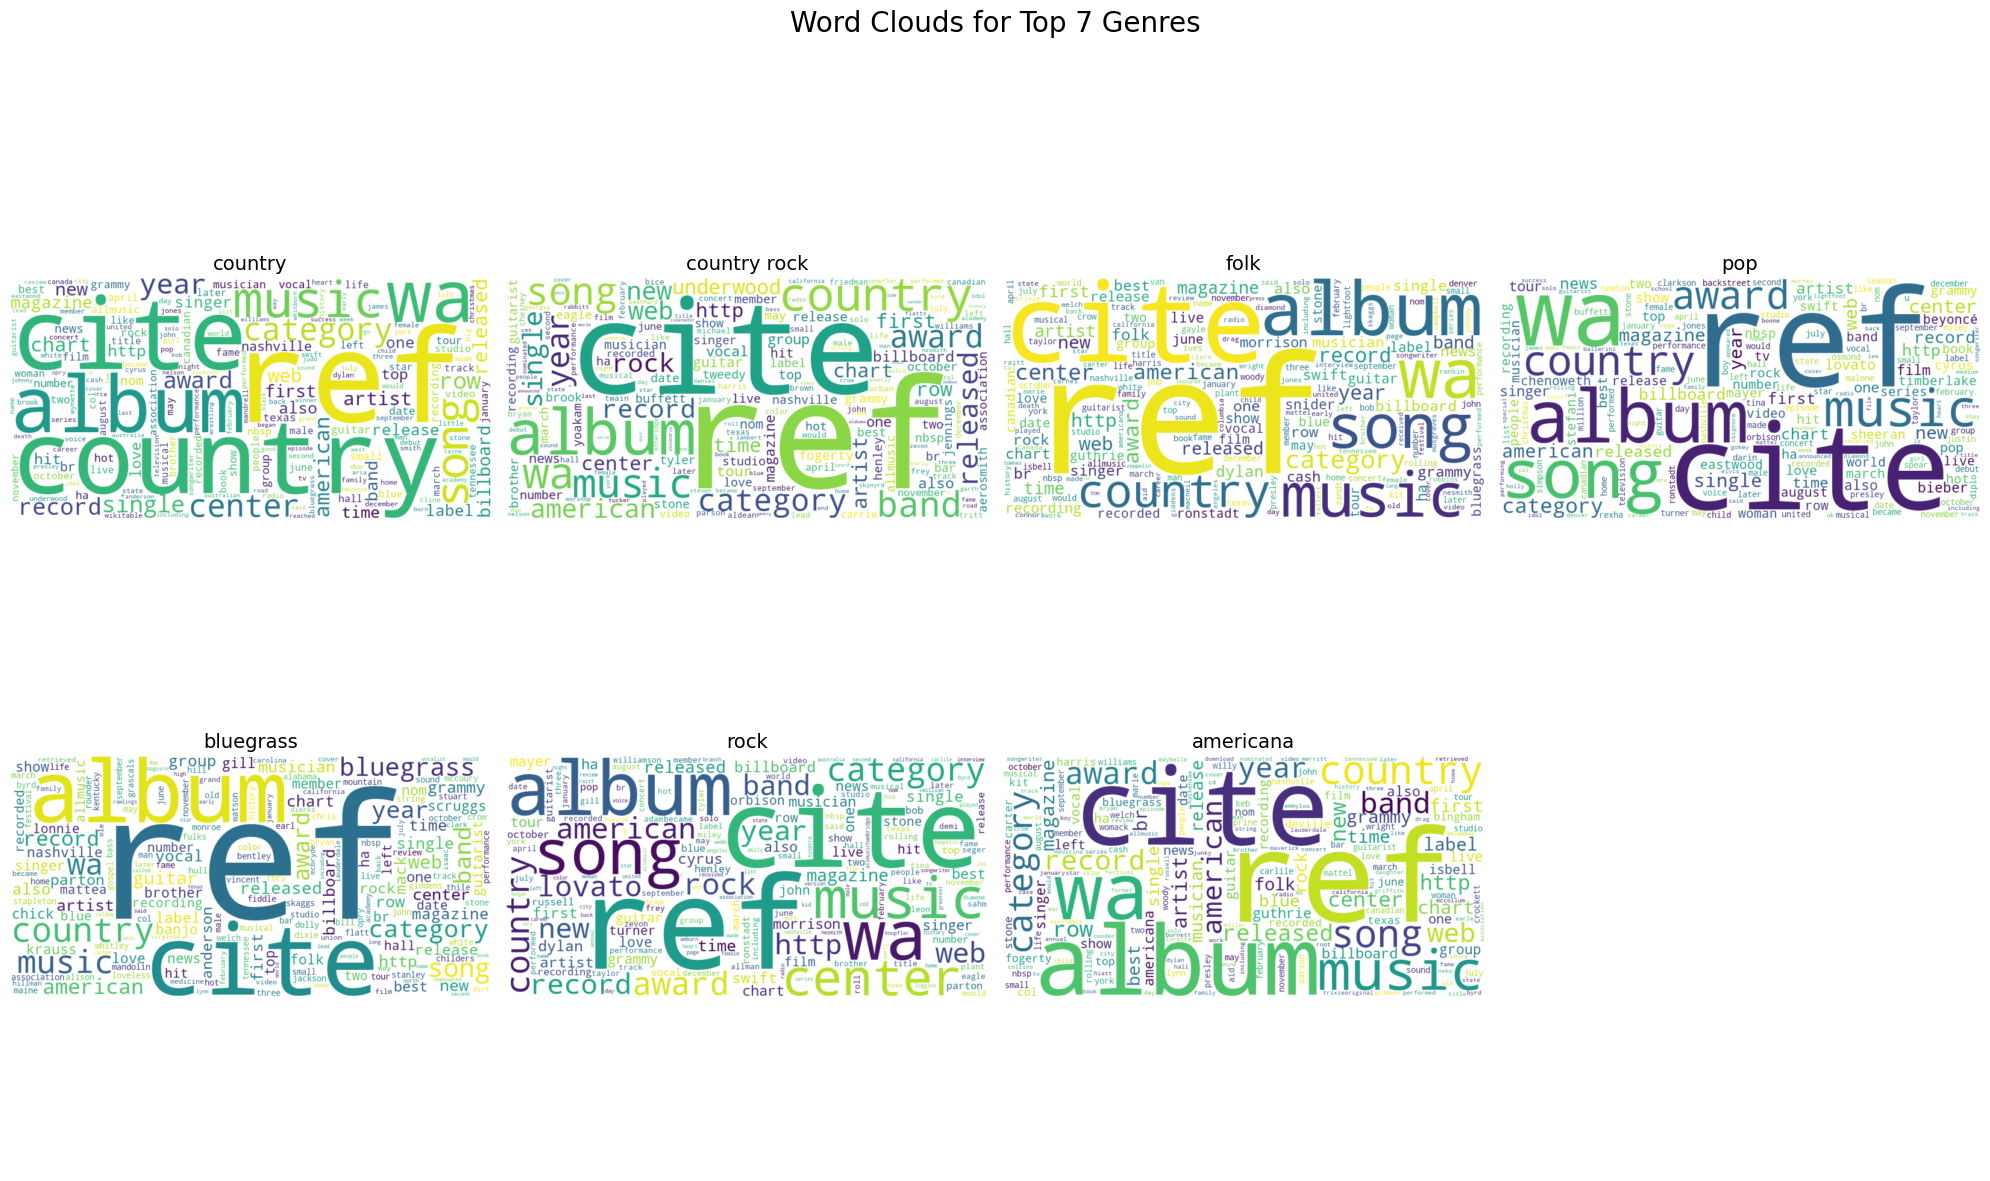

In [154]:
# TF-IDF for genre soomthed

# Initialize a dictionary to collect processed text content for each top genre
top_text_genre = defaultdict(list)

# Iterate over singers and their genres
for singer, genres in genres_data.items():
        for genre in genres:
            if genre in most_common_genres:
                file_path = os.path.join(folder_path, singer + ".txt")  # Add .txt extension
                if os.path.exists(file_path):
                    with open(file_path, 'r', encoding='utf-8') as file:
                        content = file.read()
                    
                    # Process the content
                    processed_tokens = process_text(content, lemmatize=True)
                    
                    # Join tokens back into a string and store in top_text
                    processed_content = ' '.join(processed_tokens)
                    top_text_genre[genre].append(processed_content)
                    
# Initialize a dictionary to collect TF list for each top genre
tf_list_per_genre = {}

for genre, texts in top_text_genre.items():
    # Tokenize and preprocess the text
    word_list = []
    for text in texts:
        word_list.extend(word_tokenize(text.lower()))  
    word_list = [word for word in word_list if word.isalpha()]  
    # calculate the frequency of each word
    fdist = FreqDist(word_list)
    
    # calculate the total number of words
    total_words = sum(fdist.values())
    tf_genre_list = {word: freq / total_words for word, freq in fdist.items()}
    tf_list_per_genre[genre] = tf_genre_list


# the number of documents (genres)
N = len(tf_list_per_genre)

# Count the number of documents (genres) containing each term (n_t)
term_doc_count_genre = {}
for genre, terms in tf_list_per_genre.items():
    for term in terms:# Exclude stopwords
        if term not in term_doc_count_genre:
            term_doc_count_genre[term] = 0
        term_doc_count_genre[term] += 1

# Calculate the TF-IDF scores
tf_idf_genre_scores = {}
for genre, terms in tf_list_per_genre.items():
    tf_idf_genre_scores[genre] = {}
    for term, tf in terms.items():
        n_t = term_doc_count_genre.get(term, 0)
        #calculate the idf
        idf = (math.log(N / n_t+1))
        tf_idf_genre_scores[genre][term] = math.log(1 + tf) * idf

# print the top 5 terms for each genre
for genre, terms in tf_idf_genre_scores.items():
    sorted_terms = sorted(terms.items(), key=lambda x: x[1], reverse=True)
    print(f"Top 5 terms for Community {genre}:")
    for term, score in sorted_terms[:5]:
        print(f"  - {term:<15} TF-IDF Score: {score:.4f}")
    print()

# Plot the word clouds for the top 7 genres
fig, axes = plt.subplots(2, 4, figsize=(20, 12))
fig.suptitle("Word Clouds for Top 7 Genres", fontsize=20)
axes = axes.flatten()

for i, (genre, terms) in enumerate(tf_idf_genre_scores.items()):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(terms)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(genre, fontsize=14)
    axes[i].axis('off')
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

The code below shows the TF-IDF of the genres the genres without smooth. Although the TF-IDF value is generally small, we can see a very rich vocabulary in each genre through the word cloud, and these words can be used to distinguish different genres well. In both country and country rock we can see underwood has high TF-IDF, i.e. these two genres share some same features.

Top 5 terms for Community country:
  - mandrell        TF-IDF Score: 0.0007
  - underwood       TF-IDF Score: 0.0007
  - cochran         TF-IDF Score: 0.0007
  - wrestling       TF-IDF Score: 0.0007
  - wynette         TF-IDF Score: 0.0006

Top 5 terms for Community country rock:
  - underwood       TF-IDF Score: 0.0032
  - fogerty         TF-IDF Score: 0.0022
  - tweedy          TF-IDF Score: 0.0021
  - aerosmith       TF-IDF Score: 0.0020
  - henley          TF-IDF Score: 0.0016

Top 5 terms for Community folk:
  - snider          TF-IDF Score: 0.0024
  - isbell          TF-IDF Score: 0.0013
  - morrison        TF-IDF Score: 0.0012
  - ives            TF-IDF Score: 0.0012
  - kit             TF-IDF Score: 0.0011

Top 5 terms for Community pop:
  - lovato          TF-IDF Score: 0.0032
  - chenoweth       TF-IDF Score: 0.0022
  - eastwood        TF-IDF Score: 0.0021
  - darin           TF-IDF Score: 0.0017
  - beyoncé         TF-IDF Score: 0.0017

Top 5 terms for Community bluegrass:
 

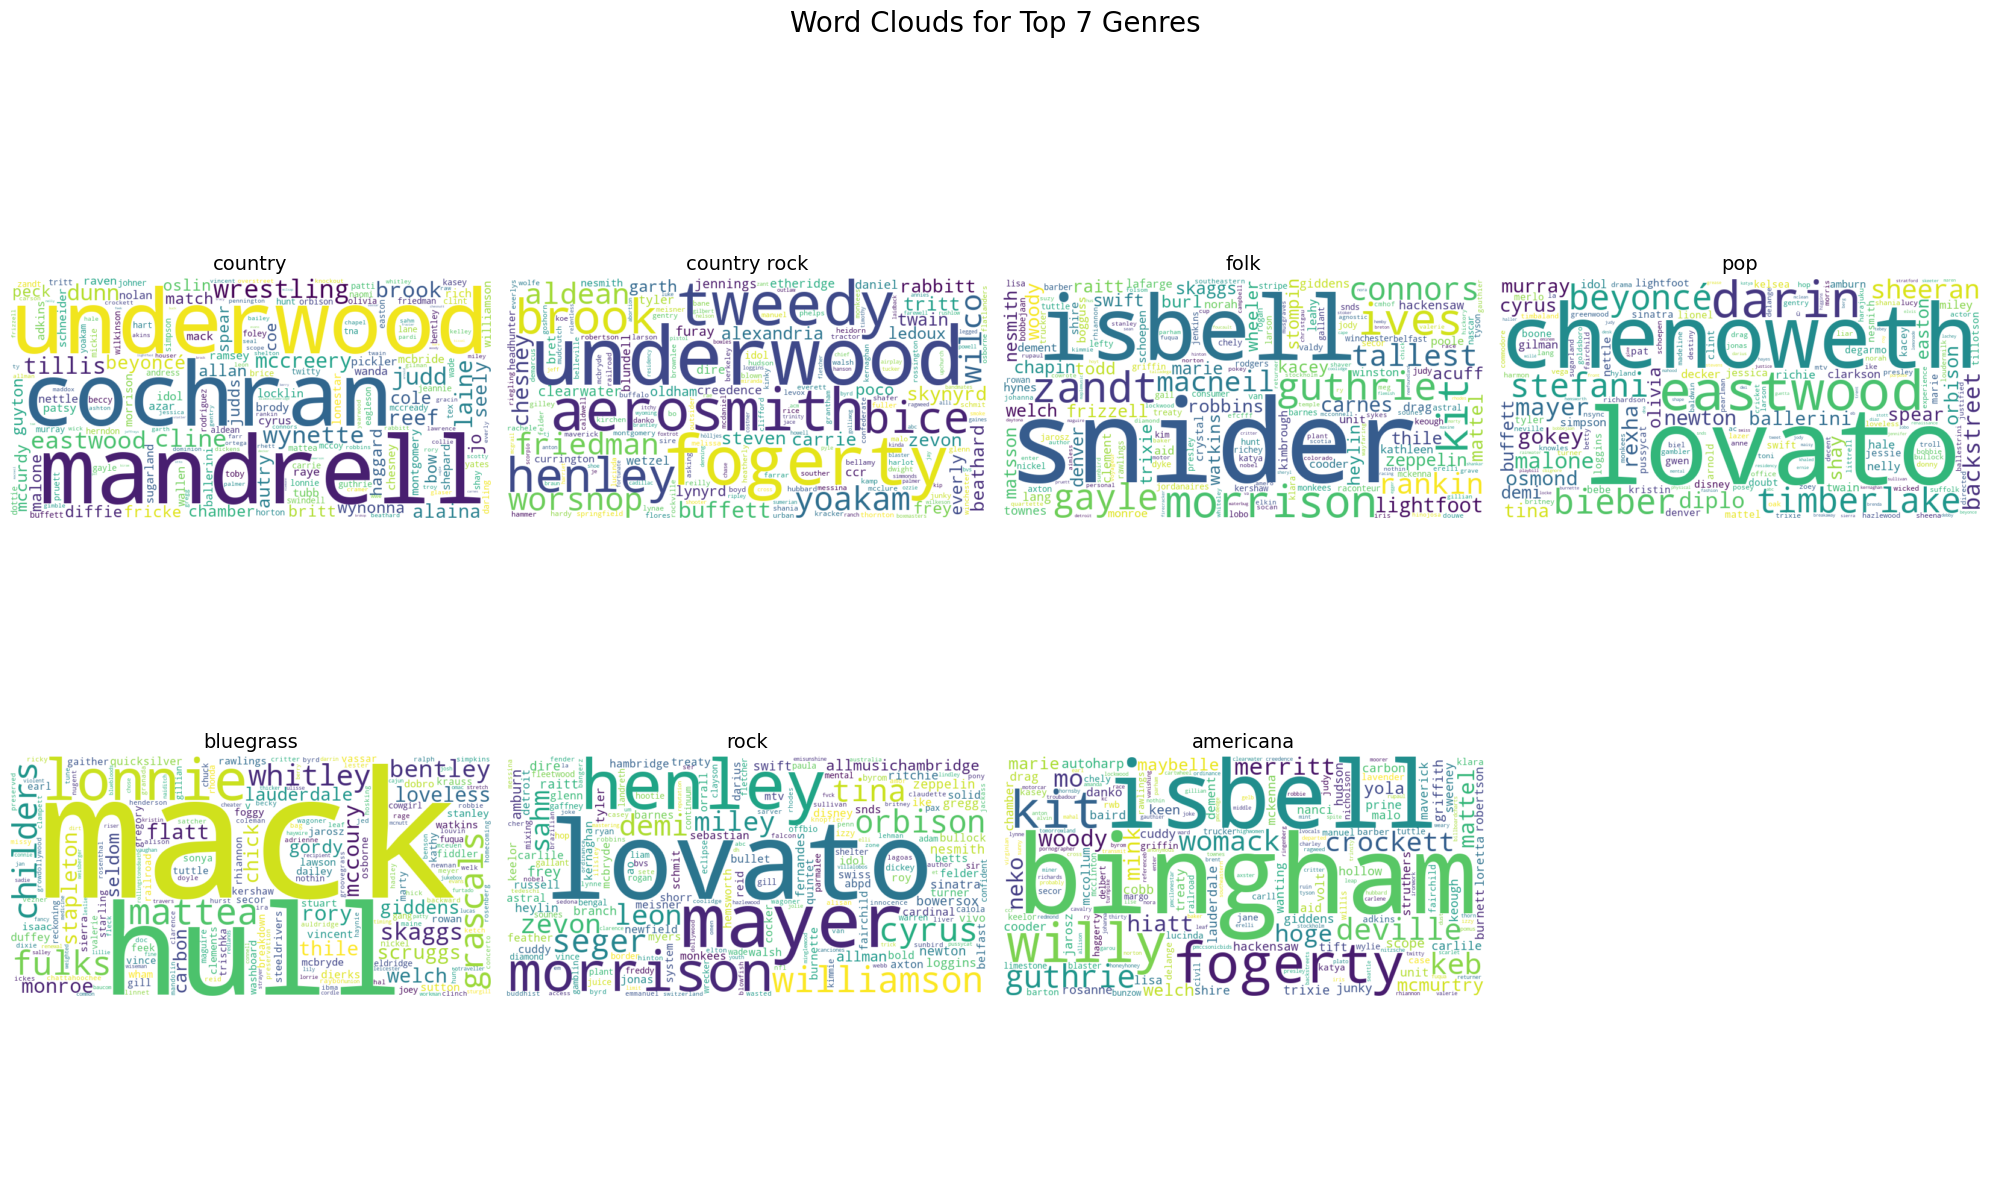

In [155]:
# TF-IDF for genre not smoothed

# Initialize a dictionary to collect processed text content for each top genre
top_text_genre = defaultdict(list)

# Iterate over singers and their genres
for singer, genres in genres_data.items():
        for genre in genres:
            if genre in most_common_genres:
                file_path = os.path.join(folder_path, singer + ".txt")  # Add .txt extension
                if os.path.exists(file_path):
                    with open(file_path, 'r', encoding='utf-8') as file:
                        content = file.read()
                    
                    # Process the content
                    processed_tokens = process_text(content, lemmatize=True)
                    
                    # Join tokens back into a string and store in top_text
                    processed_content = ' '.join(processed_tokens)
                    top_text_genre[genre].append(processed_content)
                    
# Initialize a dictionary to collect TF list for each top genre
tf_list_per_genre = {}

for genre, texts in top_text_genre.items():
    # Tokenize and preprocess the text
    word_list = []
    for text in texts:
        word_list.extend(word_tokenize(text.lower()))  
    word_list = [word for word in word_list if word.isalpha()]  
    # calculate the frequency of each word
    fdist = FreqDist(word_list)
    
    # calculate the total number of words
    total_words = sum(fdist.values())
    tf_genre_list = {word: freq / total_words for word, freq in fdist.items()}
    tf_list_per_genre[genre] = tf_genre_list


# the number of documents (genres)
N = len(tf_list_per_genre)

# Count the number of documents (genres) containing each term (n_t)
term_doc_count_genre = {}
for genre, terms in tf_list_per_genre.items():
    for term in terms:# Exclude stopwords
        if term not in term_doc_count_genre:
            term_doc_count_genre[term] = 0
        term_doc_count_genre[term] += 1

# Calculate the TF-IDF scores
tf_idf_genre_scores = {}
for genre, terms in tf_list_per_genre.items():
    tf_idf_genre_scores[genre] = {}
    for term, tf in terms.items():
        n_t = term_doc_count_genre.get(term, 0)
        #calculate the idf
        idf = (math.log(N / n_t)) ** 1.2
        tf_idf_genre_scores[genre][term] = math.log(1 + tf) * idf

# Print the top 5 terms for each community with formatted output
for genre, terms in tf_idf_genre_scores.items():
    sorted_terms = sorted(terms.items(), key=lambda x: x[1], reverse=True)
    print(f"Top 5 terms for Community {genre}:")
    for term, score in sorted_terms[:5]:
        print(f"  - {term:<15} TF-IDF Score: {score:.4f}")
    print()

# plot the word clouds
fig, axes = plt.subplots(2, 4, figsize=(20, 12))
fig.suptitle("Word Clouds for Top 7 Genres", fontsize=20)
axes = axes.flatten()

for i, (genre, terms) in enumerate(tf_idf_genre_scores.items()):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(terms)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(genre, fontsize=14)
    axes[i].axis('off')
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

Finally, we detect the TF-IDF of the communities. There is a lot of diversity between communities of the same genre, which shows that the communities segmented by the Louvain algorithm are relatively independent. Some communities are heavily focused on single genres (e.g., Community 2 with bluegrass), while others may indicate crossover interests or combined entertainment themes. 

Top 5 terms for Community 0:
  - bieber          TF-IDF Score: 0.0048
  - lovato          TF-IDF Score: 0.0035
  - timberlake      TF-IDF Score: 0.0029
  - swift           TF-IDF Score: 0.0028
  - sheeran         TF-IDF Score: 0.0026

Top 5 terms for Community 1:
  - guthrie         TF-IDF Score: 0.0030
  - mellencamp      TF-IDF Score: 0.0023
  - lightfoot       TF-IDF Score: 0.0017
  - tweedy          TF-IDF Score: 0.0016
  - henley          TF-IDF Score: 0.0016

Top 5 terms for Community 2:
  - osmond          TF-IDF Score: 0.0041
  - bluegrass       TF-IDF Score: 0.0020
  - scruggs         TF-IDF Score: 0.0017
  - diffie          TF-IDF Score: 0.0015
  - skaggs          TF-IDF Score: 0.0014

Top 5 terms for Community 5:
  - wrestling       TF-IDF Score: 0.0082
  - mccurdy         TF-IDF Score: 0.0041
  - mcgraw          TF-IDF Score: 0.0036
  - olivia          TF-IDF Score: 0.0033
  - gilman          TF-IDF Score: 0.0027

Top 5 terms for Community 6:
  - como            TF-IDF Scor

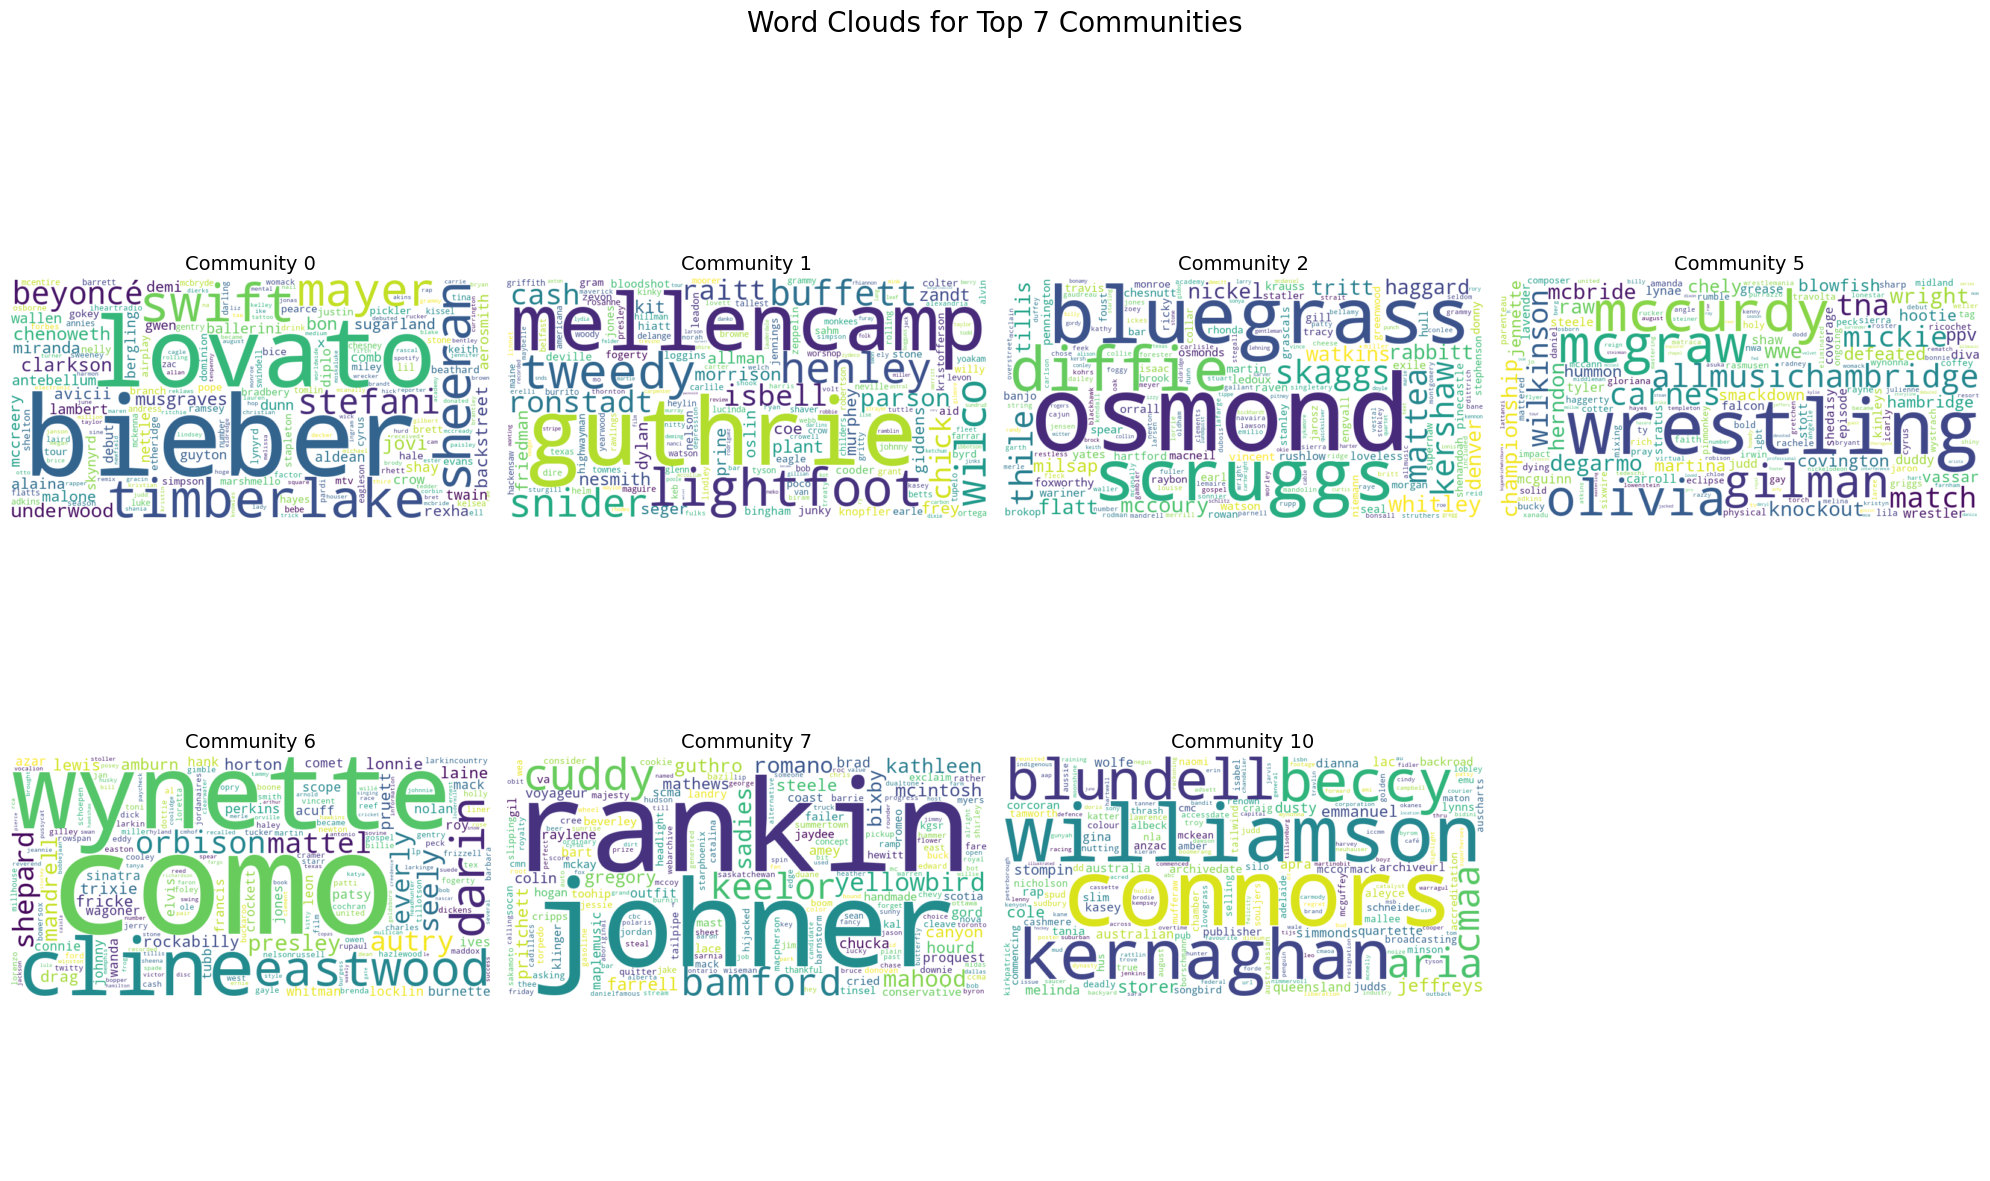

In [156]:
# Get node name and community
nodecommunity = {node: data['community'] for node, data in G_Lou.nodes(data=True)}

# Initialize a dictionary to collect processed text content for each community
top_community = defaultdict(list)

# Iterate over each singer and their community
for singer, com in nodecommunity.items():
    if com in largest_communities:  # Check if the community is among the largest communities
        file_path = os.path.join(folder_path, singer + ".txt")  # Add .txt extension
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
            
            # Process the content (e.g., tokenization and lemmatization)
            processed_tokens = process_text(content, lemmatize=True)
            processed_content = ' '.join(processed_tokens)
            top_community[com].append(processed_content)

# Initialize a dictionary to collect TF list for each community
tf_list_per_community = {}

for com, texts in top_community.items():
    # Tokenize and preprocess the text
    word_list = []
    for text in texts:
        word_list.extend(word_tokenize(text.lower()))  # Tokenize and convert to lowercase
    word_list = [word for word in word_list if word.isalpha()]  # Filter out non-alphabetic tokens
    
    # Calculate the frequency of each word
    fdist = FreqDist(word_list)
    
    # Calculate the total number of words
    total_words = sum(fdist.values())
    tf_com_list = {word: freq / total_words for word, freq in fdist.items()}
    tf_list_per_community[com] = tf_com_list

# Calculate the number of documents (communities) containing each term (n_t)
term_doc_count_com = {}
for terms in tf_list_per_community.values():
    for term in terms:
        term_doc_count_com[term] = term_doc_count_com.get(term, 0) + 1

# Calculate the TF-IDF scores
tf_idf_com_scores = {}

for com, terms in tf_list_per_community.items():
    tf_idf_com_scores[com] = {}
    for term, tf in terms.items():
        n_t = term_doc_count_com.get(term, 0)
        idf = (math.log(N / (n_t))) ** 1.2  # Add smoothing to avoid division by zero
        tf_idf_com_scores[com][term] = math.log(1 + tf) * idf  # Logarithmic scaling of TF

# Print the top 5 terms for each community with formatted output
for com, terms in tf_idf_com_scores.items():
    sorted_terms = sorted(terms.items(), key=lambda x: x[1], reverse=True)
    print(f"Top 5 terms for Community {com}:")
    for term, score in sorted_terms[:5]:
        print(f"  - {term:<15} TF-IDF Score: {score:.4f}")
    print()

# Create word clouds and visualize
fig, axes = plt.subplots(2, 4, figsize=(20, 12))
fig.suptitle("Word Clouds for Top 7 Communities", fontsize=20)
axes = axes.flatten()

for i, (com, terms) in enumerate(tf_idf_com_scores.items()):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(terms)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f"Community {com}", fontsize=14)
    axes[i].axis('off')

# Hide any remaining unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.

For better comparsion we plot the matrix again.

The word cloud and confusion matrix together show that some communities have strong correspondences with specific genres. For example, community 2 shows a clear association with bluegrass music, and you can even see bluegrass appear directly as a high-value word in the word cloud of community 2. The emergence of the 'underwood'(very high TF-IDF in country and country rock) in community 0 indicate that community 0 with a strong connection between country and country rock which fit the observation in matrix.

Some communities show characteristics that span multiple genres. For example, the word cloud for community 1 shows keywords such as "Guthrie", "Mellencamp", and "Henley" that are related to folk and country rock. This shows that this community may cover multiple types of music, not just a single genre. The distribution of folk and country rock in community 1 can also be seen in the confusion matrix.<br>
Community 6 also shows a diversity feature, with the word cloud including names such as "Wynette", "Cline", and "Como" that represent country country and traditional pop music. The confusion matrix supports this, showing that community 6 is well represented in terms of country and pop music.

In conclusion, the word cloud, community analysis, and confusion matrix show clear connections between the three, revealing the preferences and distribution characteristics of genres in specific communities. after the analysis of the information of them we can get some result that Some communities are closely associated with a single genre (such as Community 2 and Bluegrass), while others show cross-genre and regional characteristics (such as Community 1 and Community 6). 

In [157]:
print(D_df)

                 0      2      1      6      5     7     10
country       379.0  321.0  246.0  305.0  129.0  36.0  31.0
folk            9.0   30.0   95.0   26.0    3.0   4.0   5.0
country rock   57.0   18.0   63.0   14.0    4.0   0.0   5.0
pop            48.0   13.0   31.0   48.0   11.0   2.0   2.0
americana      15.0   16.0   98.0   12.0    4.0   3.0   1.0
bluegrass      10.0   77.0   31.0    7.0    1.0   0.0   0.0
rock           21.0   16.0   50.0   14.0    6.0   3.0   3.0


# Part 3: Sentiment of the artists and communities

The questions below are based on Lecture 8

* Calculate the sentiment of the Artists pages (OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.
* Discuss the sentiment of the largest communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?

For Sentiment distribution we used LabMT wordlist, you can find more information in [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752).

In [158]:
# A method for calculation of the sentiment
def calculate_sentiment(tokens, labmt_path='labMT.txt'):
    # Read the LabMT data into a dictionary
    word_sentiment = {}
    with open(labmt_path, 'r', encoding='utf-8') as file:
        for line in file:
            # Skip lines that are headers or irrelevant
            if 'happiness_average' in line or line.startswith('word'):
                continue
            parts = line.strip().split('\t')
            if len(parts) >= 3:
                try:
                    word = parts[0].lower()
                    sentiment_score = float(parts[2])
                    word_sentiment[word] = sentiment_score
                except ValueError:
                    continue  # Skip lines that do not convert properly

    # Gather sentiment scores for the tokens
    scores = [word_sentiment[token.lower()] for token in tokens if token.lower() in word_sentiment]

    # Check if there are valid scores
    if scores:
        avg_score = np.mean(scores)
        median_score = np.median(scores)
        variance_score = np.var(scores)
        percentile_25 = np.percentile(scores, 25)
        percentile_75 = np.percentile(scores, 75)

        return {
            'average': avg_score,
            'median': median_score,
            'variance': variance_score,
            '25th_percentile': percentile_25,
            '75th_percentile': percentile_75
        }
    else:
        return None  # Return None if no valid words were found

In [159]:
#Iterage over the nodes in your network, tokenize each page, and calculate sentiment every single page. Now you have sentiment as a new nodal property.
folder_path = 'wikipedia_pages'  
G1=G.copy()

# Calculate the sentiment for every single page in graph.
node_sentiment = {}
for node in list(G1.nodes()):
    file_path = os.path.join(folder_path, node + ".txt")  # Add .txt extension
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            tokens = word_tokenize(content)
            node_sentiment[node] = calculate_sentiment(tokens)
nx.set_node_attributes(G1, node_sentiment, 'sentiment')

For better analysis, we plot the histograms with the median, variance, 25th percentile, 75th percentileas etc.As can be seen from the figure, the sentiment scores of most pages are concentrated between 5.5 and 5.7, showing a shape of approximate normal distribution. This indicates that the emotional scores of most artist pages are in the range of near neutral to positive, with fewer pages with extreme emotions. The mean and median emotional scores are almost coincident, indicating that there is no significant deviation from the overall score. Meanwhile, from the results of the 25% and 75% quantiles, it can be seen that 25% of the artist pages have an emotional score below 5.59, while 75% of the pages have an emotional score below 5.70.

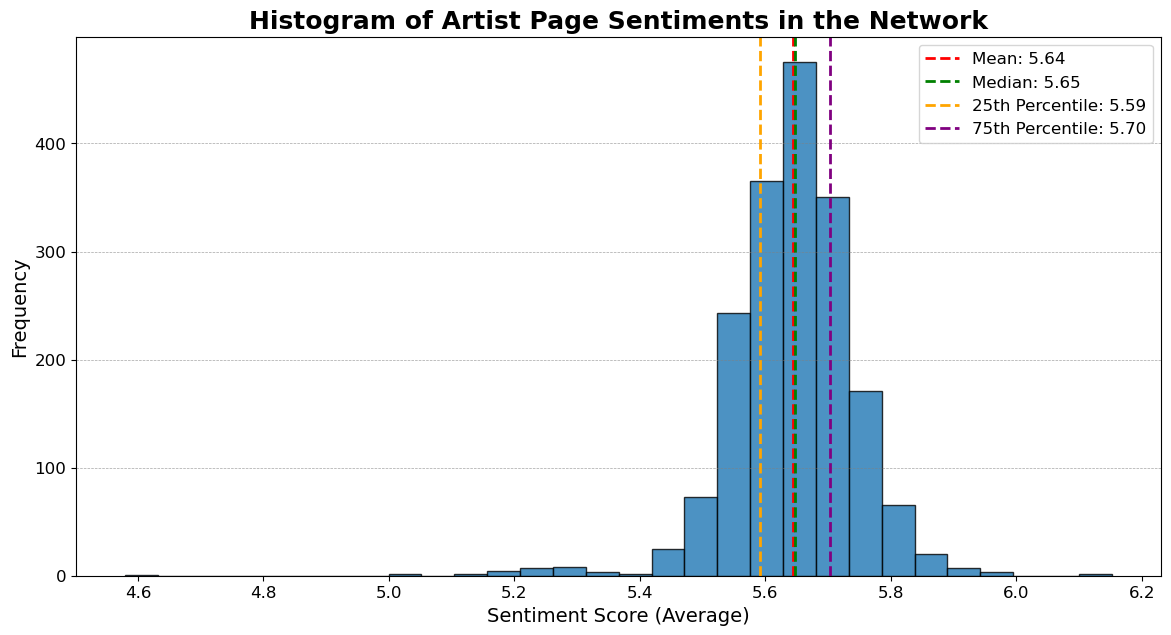

In [160]:
# Extract the 'average' sentiment attribute from all nodes in the graph
average_sentiments = [data['sentiment']['average'] for _, data in G1.nodes(data=True) if 'sentiment' in data and data['sentiment']]

# Calculate statistics
mean_value = np.mean(average_sentiments)
median_value = np.median(average_sentiments)
variance_value = np.var(average_sentiments)
percentile_25 = np.percentile(average_sentiments, 25)
percentile_75 = np.percentile(average_sentiments, 75)

# Create a histogram with improved aesthetics
plt.figure(figsize=(14, 7))
plt.hist(average_sentiments, bins=30, edgecolor='black', alpha=0.8)
plt.axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='green', linestyle='--', linewidth=2, label=f'Median: {median_value:.2f}')
plt.axvline(percentile_25, color='orange', linestyle='--', linewidth=2, label=f'25th Percentile: {percentile_25:.2f}')
plt.axvline(percentile_75, color='purple', linestyle='--', linewidth=2, label=f'75th Percentile: {percentile_75:.2f}')

# Add title and labels with improved font size and style
plt.title('Histogram of Artist Page Sentiments in the Network', fontsize=18, fontweight='bold')
plt.xlabel('Sentiment Score (Average)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Customize legend
plt.legend(fontsize=12)

# Add a grid for better readability
plt.grid(axis='y', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Enhance tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

we can also find the saddest singers and happiest sinfers for more information

From the ten saddest singers, we can find that some of their songs have a lot of sad themes, and their corresponding lyrics are also full of sad content. For example, country music such as Jimmie Rodgers, Foggy Mountain Boys, which include elements of hardship and homesickness, have received negative scores. Meanwhile, some singers' homepages have experienced some unfavorable life situations due to their career setbacks and difficulties in life, such as Brian Kelley, which have led to negative themes affecting their emotional scores. 

Among the top ten singers, some have a modern music style such as Gina Jeffreys, whose works are more positive and have relaxed vibe. Meanwhile, music genres such as Troy Cassar-Daley, which are more focused on growth and celebrating life, have also had a positive impact. In the biographies of some singers, there are also more positive words because their careers have grown smoothly and successfully.

In [161]:
# Find the 10 nodes with the lowest 'average' sentiment scores
saddest_nodes = sorted(
    [(node, data['sentiment']['average']) for node, data in G1.nodes(data=True) if 'sentiment' in data and data['sentiment']],
    key=lambda x: x[1]
)[:10]

# Find the 10 nodes with the highest 'average' sentiment scores
happiest_nodes = sorted(
    [(node, data['sentiment']['average']) for node, data in G1.nodes(data=True) if 'sentiment' in data and data['sentiment']],
    key=lambda x: x[1],
    reverse=True
)[:10]

# Create DataFrames to display the results
saddest_nodes_df = pd.DataFrame(saddest_nodes, columns=['Node', 'Average Sentiment'])
happiest_nodes_df = pd.DataFrame(happiest_nodes, columns=['Node', 'Average Sentiment'])

# Print the DataFrames
print("Top 10 Saddest Nodes:")
display(saddest_nodes_df)

print("\nTop 10 Happiest Nodes:")
display(happiest_nodes_df)

Top 10 Saddest Nodes:


Node  Average Sentiment
0  Jimmie Rodgers (country singer)           4.580000
1          Brian Kelley (musician)           5.022000
2    Jason Boland & the Stragglers           5.050000
3              Foggy Mountain Boys           5.132500
4                  Flatt & Scruggs           5.136000
5           Infamous Stringdusters           5.165000
6        The Wrights (country duo)           5.165000
7                     Joanna Smith           5.172000
8                    Kerry Harvick           5.175556
9                        Tim Mensy           5.225000


Top 10 Happiest Nodes:


Node  Average Sentiment
0  Flying Burrito Brothers           6.152500
1         Jewel (musician)           6.120000
2           Bacon Brothers           5.973333
3        Troy Cassar-Daley           5.952954
4     Allman Brothers Band           5.950000
5           McAlister Kemp           5.928157
6            Gina Jeffreys           5.925456
7              Adam Harvey           5.923196
8          Dianna Corcoran           5.915304
9    Spirit Family Reunion           5.904794

#### Discuss the sentiment of the largest communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?

Calculating by the code below. The three Happiest Communities:<br>
Kasey Chambers, Catherine Britt, Beccy Cole  - Average Sentiment: 5.7946<br>
George Canyon, Blue Rodeo, Jim Cuddy - Average Sentiment: 5.7200<br>
Sean Hogan, Duane Steele, Brad Johner  - Average Sentiment: 5.7056<br>

The three Saddest Communities:<br>
Willie Nelson, Emmylou Harris, Bob Dylan - Average Sentiment: 5.6368<br>
Johnny Cash, Merle Haggard, George Jones - Average Sentiment: 5.6053<br>
Brandon Jenkins, Cross Canadian Ragweed, Cody Canada - Average Sentiment: 5.5876<br>

Comparing these communities with genre information, word clouds, and Wikipedia pages for each community. For one of saddest communities, The Willie Nelson, Emmylou Harris, Bob Dylan  community has a somber tone, fitting their association with more traditional country and southern rock styles.Their music often focuses on themes of heartbreak, struggle, and social issues. Word clouds in these communities likely feature more negative or melancholic words such as “loss,” “pain,” and “loneliness,” matching their lower sentiment scores. Also for the happiest community, like Kasey Chambers, Catherine Britt, Beccy Cole  community. From wiki page, we know they consists of artists known for upbeat and often celebratory themes, especially in modern country music. Their word clouds highlight positive, light-hearted themes such as love, laughter, and hometown, supporting the high sentiment.

The results largely align with the genre characteristics, word clouds, and Wikipedia information. Communities centered around country and folk artists known for introspective, often melancholic lyrics tend to have lower sentiment scores, while those with themes of celebration and positivity show higher sentiment. This confirms that genre and thematic focus are significant influences on the emotional tone of each community, as expected.

In [162]:
Glouvain=G1.copy()
partition = community.best_partition(Glouvain)
# Count the number of nodes in each community
community_counts = Counter(partition.values())

# Find the top 10 largest communities by node count
top_communities = [comm for comm, _ in community_counts.most_common(10)]

# Create a dictionary to map community IDs to their top 3 most connected nodes
community_representatives = {}

for comm_id in top_communities:
    # Filter nodes belonging to the current community
    nodes_in_community = [node for node, comm in partition.items() if comm == comm_id]
    # Sort nodes by their degree (number of connections)
    top_nodes = sorted(nodes_in_community, key=lambda n: Glouvain.degree(n), reverse=True)[:3]
    # Use these top 3 nodes as the representative names for the community
    community_representatives[comm_id] = top_nodes

# Modify the partition dictionary to include community labels
for node, comm_id in list(partition.items()):
    if comm_id in community_representatives:
        partition[node] = (community_representatives[comm_id])  # Tuple format: (community_id, representative_nodes)

# Initialize community sentiment dictionary using tuples as keys and skipping integers
community_sentiment = {
    tuple(com): [] for com in partition.values() if isinstance(com, list)
}

# Calculate sentiment for each node and add it to the respective community's list
for node, com in partition.items():
    # Only process if `com` is a list (converted to a tuple as the key)
    if isinstance(com, list):
        com_key = tuple(com)
        
        file_path = os.path.join(folder_path, node + ".txt")  # Add .txt extension
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                tokens = word_tokenize(content)
                sentiment = calculate_sentiment(tokens)
                if sentiment:
                    community_sentiment[com_key].append(sentiment)
# Calculate the average sentiment for each community
average_community_sentiment = {
    com: np.mean([s['average'] for s in sentiments]) if sentiments else 0
    for com, sentiments in community_sentiment.items()
}

# Find the 3 happiest and 3 saddest communities based on average sentiment
sorted_communities = sorted(average_community_sentiment.items(), key=lambda x: x[1], reverse=True)
happiest_communities = sorted_communities[:3]
saddest_communities = sorted_communities[-3:]
print(f"saddest_communities: {saddest_communities}")
print(f"happiest_communities: {happiest_communities}")

saddest_communities: [(("Stompin' Tom Connors", 'Tommy Hunter', 'Cindy Church'), 5.601466508697827), (('Cross Canadian Ragweed', 'Cody Canada', 'Mike McClure'), 5.583211470027696), (('Andrew Jenkins (songwriter)', 'Vernon Dalhart', "Fiddlin' John Carson"), 5.56800847907399)]
happiest_communities: [(('Beccy Cole', 'Troy Cassar-Daley', 'Amber Lawrence'), 5.806141302515424), (('Reba McEntire', 'Keith Urban', 'Brooks & Dunn'), 5.6802743912909195), (('The Wilkinsons', 'Amanda Wilkinson', 'Small Town Pistols'), 5.660900305576777)]


The distribution of every communities are presented as follow:

From the following 10 largest communities and their corresponding sentiment score distribution charts, it can be observed that most of the singers are concentrated in several larger communities, such as Reba McEntire, Keith Urban、Brooks & Dunn communities. The distribution of sentiment scores presents a normal distribution shape, indicating that the sentiment scores of artist pages in these communities are evenly and centrally distributed. However, for some small communities, such as George Canyon and Sean Hogan, the distribution of sentiment scores appears uneven, showing a discrete distribution characteristic, possibly due to the small sample size.

After comparing the two communities with extreme sentiments with the overall network's sentiment distribution, the most positive sentiment score community represented by Kasey Chambers, Catherine Britt, Beccy Cole has a slightly higher average score than the overall network's average of 5.64, but this score is not significantly higher than the overall network's average, and its distribution is still relatively close to the overall network's sentiment distribution. The community represented by Johnny Cash, Merle Haggard, and George Jones has a low average score, but its overall distribution is still close to the overall distribution of the network, only slightly lower, and does not significantly deviate from the average sentiment distribution of the entire network.

Based on the previous TF-IDF analysis, we identified key words that are significant to the themes within each community. These lexical-level insights provide valuable context for sentiment outcomes. By recognizing keywords associated with various genres or singer groups, we can pinpoint themes such as "heartbreak," "struggle," "joy," and "celebration" within each community. For instance, in the communities of Kasey Chambers and Catherine Britt, the TF-IDF keywords are related to "celebrate," "love," and "joy," which explains the higher sentiment scores in this community. Meanwhile, some communities have both positive and negative TF-IDF keywords, leading to a neutral sentiment distribution. For example, the communities of George Strait and Garth Brooks contain both positive and negative keywords like "party," "celebrate," "heartbreak," and "loss," which explains why the sentiment scores of this group are close to the average.

C:\Users\wuqiu\AppData\Local\Temp\ipykernel_19812\837751139.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(communities_with_sentiments))  # Use 'tab10' colormap for up to 10 distinct colors


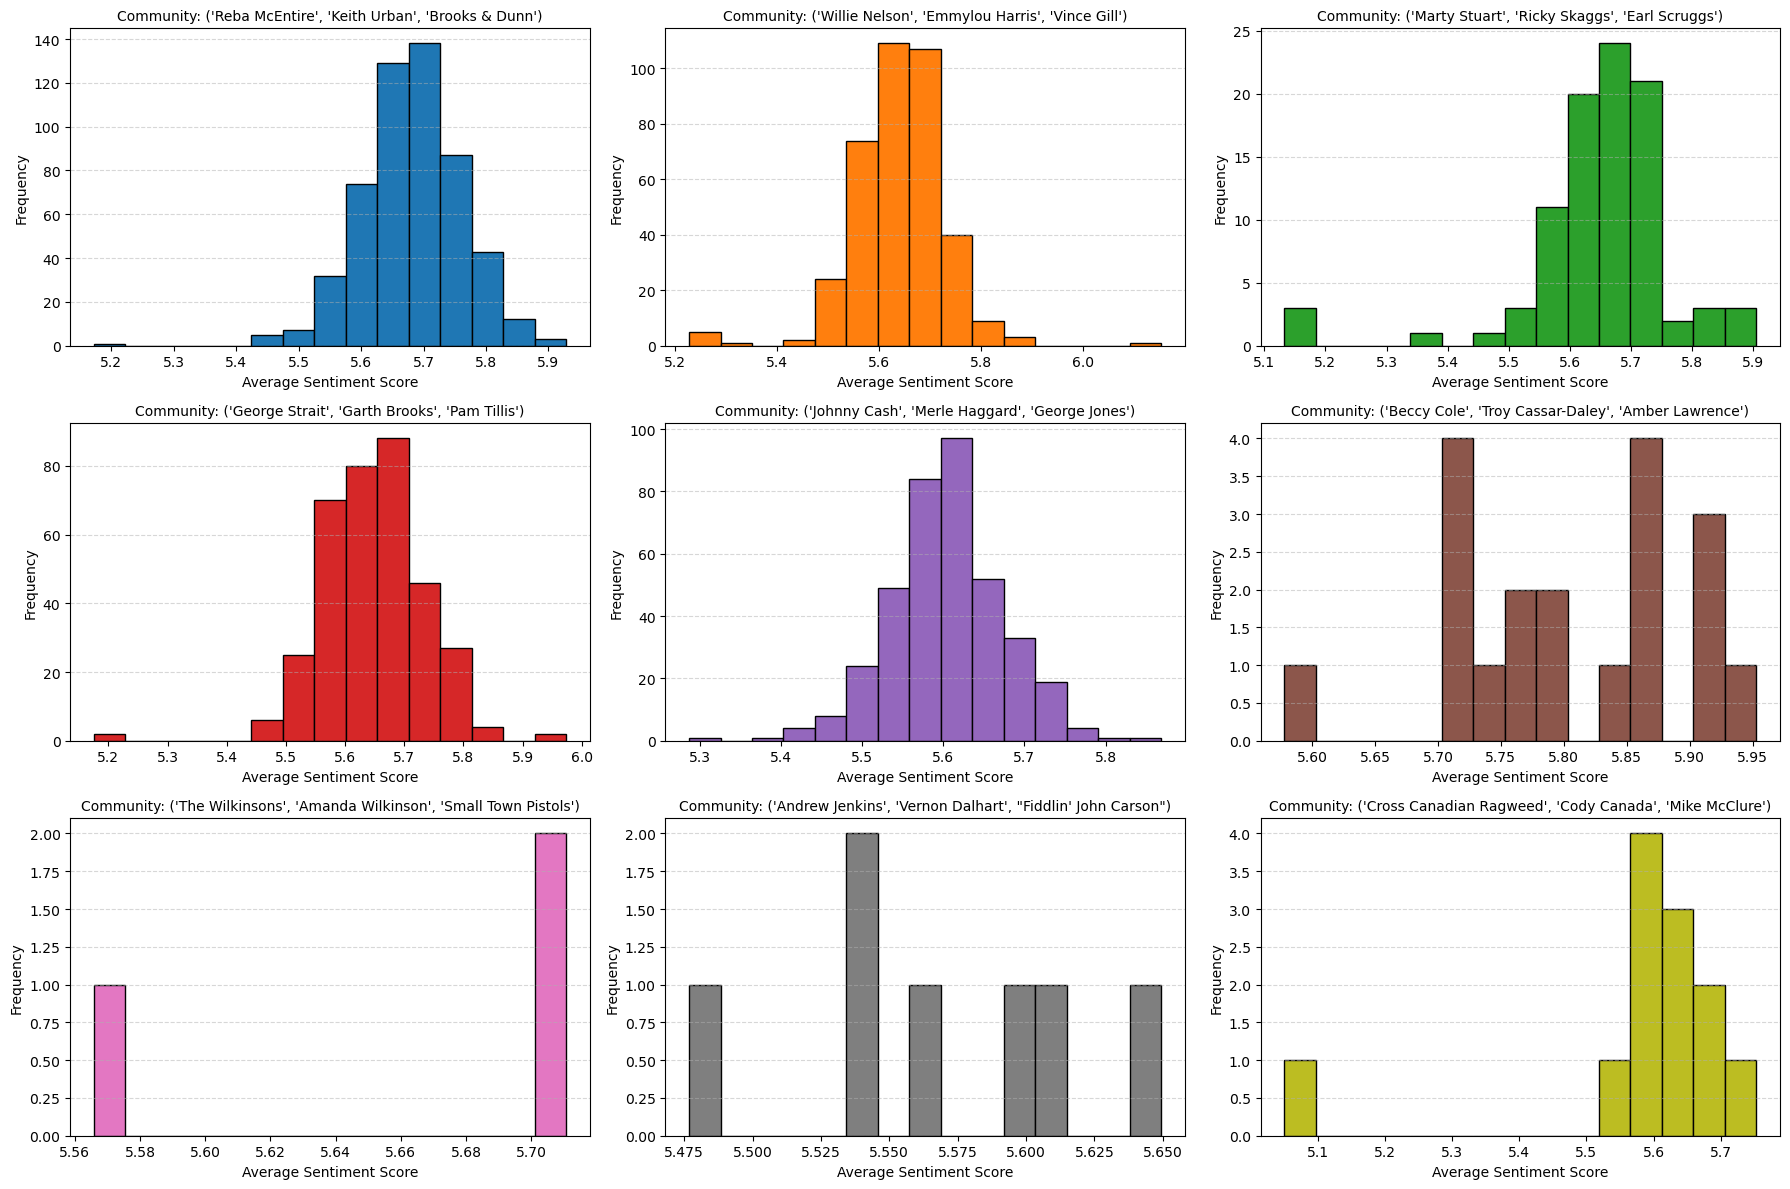

In [163]:
def plot_subplots(community_sentiment):
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    axes = axes.flatten()  # Flatten the 3x3 array to iterate over

    # Filter communities that have sentiment data
    communities_with_sentiments = [(com, sentiments) for com, sentiments in community_sentiment.items() if sentiments]
    
    # Generate a list of colors or use a color map for diversity
    colors = plt.cm.get_cmap('tab10', len(communities_with_sentiments))  # Use 'tab10' colormap for up to 10 distinct colors
    
    for i, (com, sentiments) in enumerate(communities_with_sentiments[:9]):  # Only plot up to 9 communities
        average_scores = [s['average'] for s in sentiments if 'average' in s]
        axes[i].hist(average_scores, bins=15, color=colors(i), edgecolor='black')  # Use a different color for each community
        title = tuple(re.sub(r'\s*\(.*?\)', '', name) for name in com)
        axes[i].set_title(f'Community: {title}', fontsize=10)
        axes[i].set_xlabel('Average Sentiment Score')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(axis='y', linestyle='--', alpha=0.5)

    # Hide any unused subplots
    for j in range(len(communities_with_sentiments), 9):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Example call to plot 3x3 subplots for the community sentiment histograms
plot_subplots(community_sentiment)